In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [2]:
df = pd.read_csv('../FormattedData/AIZ_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [3]:
# This function removes highly correlated variables within the dataset. The function looks at the 
# Pearson Correlation Coefficient between every pair of variables in the dataset and returns all 
# of those between .8 and .999. While working with data from different companies, I found that by
# removing the first 90% of correlated variables within the DataFrame, in almost all cases, there
# were no longer correlations within the dataset.

In [4]:
def remove_corrs(df):
    
    # create a DataFrame with all the of the correlation coefficients, and then stack the pairings.
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    # create a temoporary DataFrame that contains all the pairs of variables that have a correlation
    # between .8 and .999. Because the .corr() method returns the pairings in both directions, I only
    # look at half of the cells because of duplicates.
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    # look at how many times each variable shows up in the correlation column
    corr_index = correlations['1'].value_counts().index
    # delete the first 90% of the variables. This generally removes the columns that are most correlated with the others. 
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [5]:
# This function preprocesses my data so it is ready for distanced based regressions.

def preprocess_data(df, target_var = 'close'):
    
    df.index = pd.to_datetime(df.index)
    
    # Here, I shift all the independent variables back one day in order to make sure there is
    # no data leakage. Because we're trying to predict closing price, we can't know many of
    # things that happen throughout the day we're trying to predict.
    X = df.shift(1).dropna()
    
    # This is the function described above.
    X_data = remove_corrs(X)

    # Because I am running a regression, I can use a continuous variable as my dependent variable.
    # Ideally, my algorithim can predict the closing price at the end of the day with accuracy.
    y = df[target_var].iloc[1:]
    
    # Do a train test split with the first 80% of the data being the training set and the last 20%
    # as the testing set.
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)

    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    # Because I am doing distance based regressions, I need to scale the data so that variables with
    # higher absolute values don't dominate the metrics.
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = preprocess_data(df)

1798 450


In [7]:
svr = LinearSVR(random_state = 42, max_iter = 10e4)

In [8]:
svrmodel = svr.fit(X_train, y_train)

C:\Users\TJ Bray\.conda\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [13]:
preds_train = svr.predict(X_train)
preds_test = svr.predict(X_test)
print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9298901789482603
Train RMSE : 5.82021778703812
Mean Train Cross-Validation Score: -1.4896010408253901


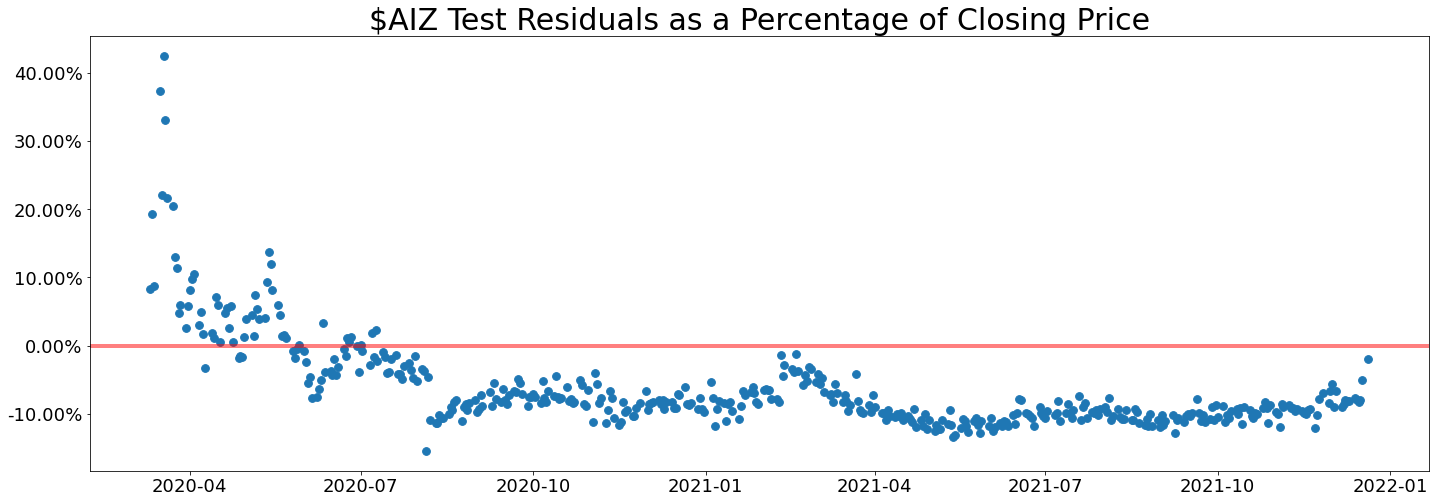

In [41]:
fig, ax = plt.subplots(figsize = (24,8))
ax2_x = y_test.index
ax2_y = (y_hat_test - y_test)/y_test
ax.scatter(ax2_x,ax2_y, s = 60)
ax.yaxis.set_major_formatter('{x:1,.2%}')
ax.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0)
ax.tick_params(axis = 'both', which  = 'major', labelsize = 18)
ax.set_title('$AIZ Test Residuals as a Percentage of Closing Price', fontsize = 30);